In [1]:
# In a new cell: Basic Imports and Setup
import os
import sys
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy

# Add project root to path to import custom utils
try:
    PROJECT_ROOT = Path(__file__).parent.parent.parent
except NameError:
    PROJECT_ROOT = Path.cwd().parent.parent

sys.path.insert(0, str(PROJECT_ROOT))
print(f"Project Root: {PROJECT_ROOT}")

from utils.experiment_manager import ExperimentManager
from utils.experiment_analysis import ExperimentAnalyzer

# Set plotting style
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_context("talk")
sns.set_style("whitegrid")

/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/minhang/miniconda3/envs/mds_

Project Root: /home/minhang/mds_project/sc_classification


In [2]:
# In a new cell: Define Experiment Paths
BASE_EXPERIMENT_DIR = PROJECT_ROOT / "experiments"

# --- Experiment IDs ---
# The original "all_filtered" run with per-patient LR
PER_PATIENT_EXP_ID = "20250811_015935_fa_100_random_all_filtered_9be6903b"
# The new pan-patient runs
PAN_PATIENT_NO_CV_EXP_ID = "20250812_190804_fa_100_none_all_filtered_e2c36430"
PAN_PATIENT_CV_EXP_ID = "20250812_215722_fa_100_none_all_filtered_cfd8482f"

# Create a helper dictionary for the pan-patient experiments
pan_patient_experiments = {
    "no_cv": {
        "id": PAN_PATIENT_NO_CV_EXP_ID,
        "path": BASE_EXPERIMENT_DIR / PAN_PATIENT_NO_CV_EXP_ID,
        "label": "Pan-Patient (No CV)"
    },
    "with_cv": {
        "id": PAN_PATIENT_CV_EXP_ID,
        "path": BASE_EXPERIMENT_DIR / PAN_PATIENT_CV_EXP_ID,
        "label": "Pan-Patient (with CV)"
    }
}

# Path for the per-patient comparison experiment
per_patient_exp_path = BASE_EXPERIMENT_DIR / PER_PATIENT_EXP_ID

### Sanity Check: Comparing Per-Patient vs. Pan-Patient Factor Analysis
Before analyzing the classifiers, it's crucial to confirm our assumption that the upstream Dimension Reduction (DR) step is identical. Both the per-patient and pan-patient experiments used the "all-genes-filtered" preprocessing method, which is applied to the full cohort of MRD cells. The Factor Analysis is then run on this full preprocessed dataset.

In [3]:
# In a new cell: FA Sanity Check
print("--- Comparing Factor Analysis Loadings ---")

# Load FA loadings from the per-patient experiment
adata_per_patient_path = per_patient_exp_path / "models" / "fa_100" / "transformed_data.h5ad"
adata_per_patient = sc.read_h5ad(adata_per_patient_path)
loadings_per_patient = adata_per_patient.varm['FA_loadings']

# Load FA loadings from the pan-patient experiment (no CV)
adata_pan_patient_path = pan_patient_experiments['no_cv']['path'] / "models" / "fa_100" / "transformed_data.h5ad"
adata_pan_patient = sc.read_h5ad(adata_pan_patient_path)
loadings_pan_patient = adata_pan_patient.varm['FA_loadings']

# Check if they are numerically close (accounting for potential floating point dust)
are_identical = np.allclose(loadings_per_patient, loadings_pan_patient)

if are_identical:
    print("✅ SUCCESS: The Factor Analysis loadings are numerically identical between the two experiments.")
else:
    print("❌ FAILURE: The Factor Analysis loadings are different. Check the pipeline configurations.")


--- Comparing Factor Analysis Loadings ---
✅ SUCCESS: The Factor Analysis loadings are numerically identical between the two experiments.


## Downstream Analysis for the Pan-Patient Model

In [3]:
# In a new cell: Initialize Analyzer
manager = ExperimentManager(BASE_EXPERIMENT_DIR)
analyzer = ExperimentAnalyzer(manager)

In [1]:
'''
# In a new cell: Run GSEA on Global Factors
print("\n" + "="*80)
print(f"RUNNING GSEA ON GLOBAL FACTORS FOR: {pan_patient_experiments['no_cv']['label']}")
print("="*80)

analyzer.run_gsea_on_factors(
    experiment_id=pan_patient_experiments['no_cv']['id'],
    rescale_loadings=False 
)
'''

'\n# In a new cell: Run GSEA on Global Factors\nprint("\n" + "="*80)\nprint(f"RUNNING GSEA ON GLOBAL FACTORS FOR: {pan_patient_experiments[\'no_cv\'][\'label\']}")\nprint("="*80)\n\nanalyzer.run_gsea_on_factors(\n    experiment_id=pan_patient_experiments[\'no_cv\'][\'id\'],\n    rescale_loadings=False \n)\n'

--- Analyzing metrics for Pan-Patient experiment: 20250812_190804_fa_100_none_all_filtered_e2c36430 ---


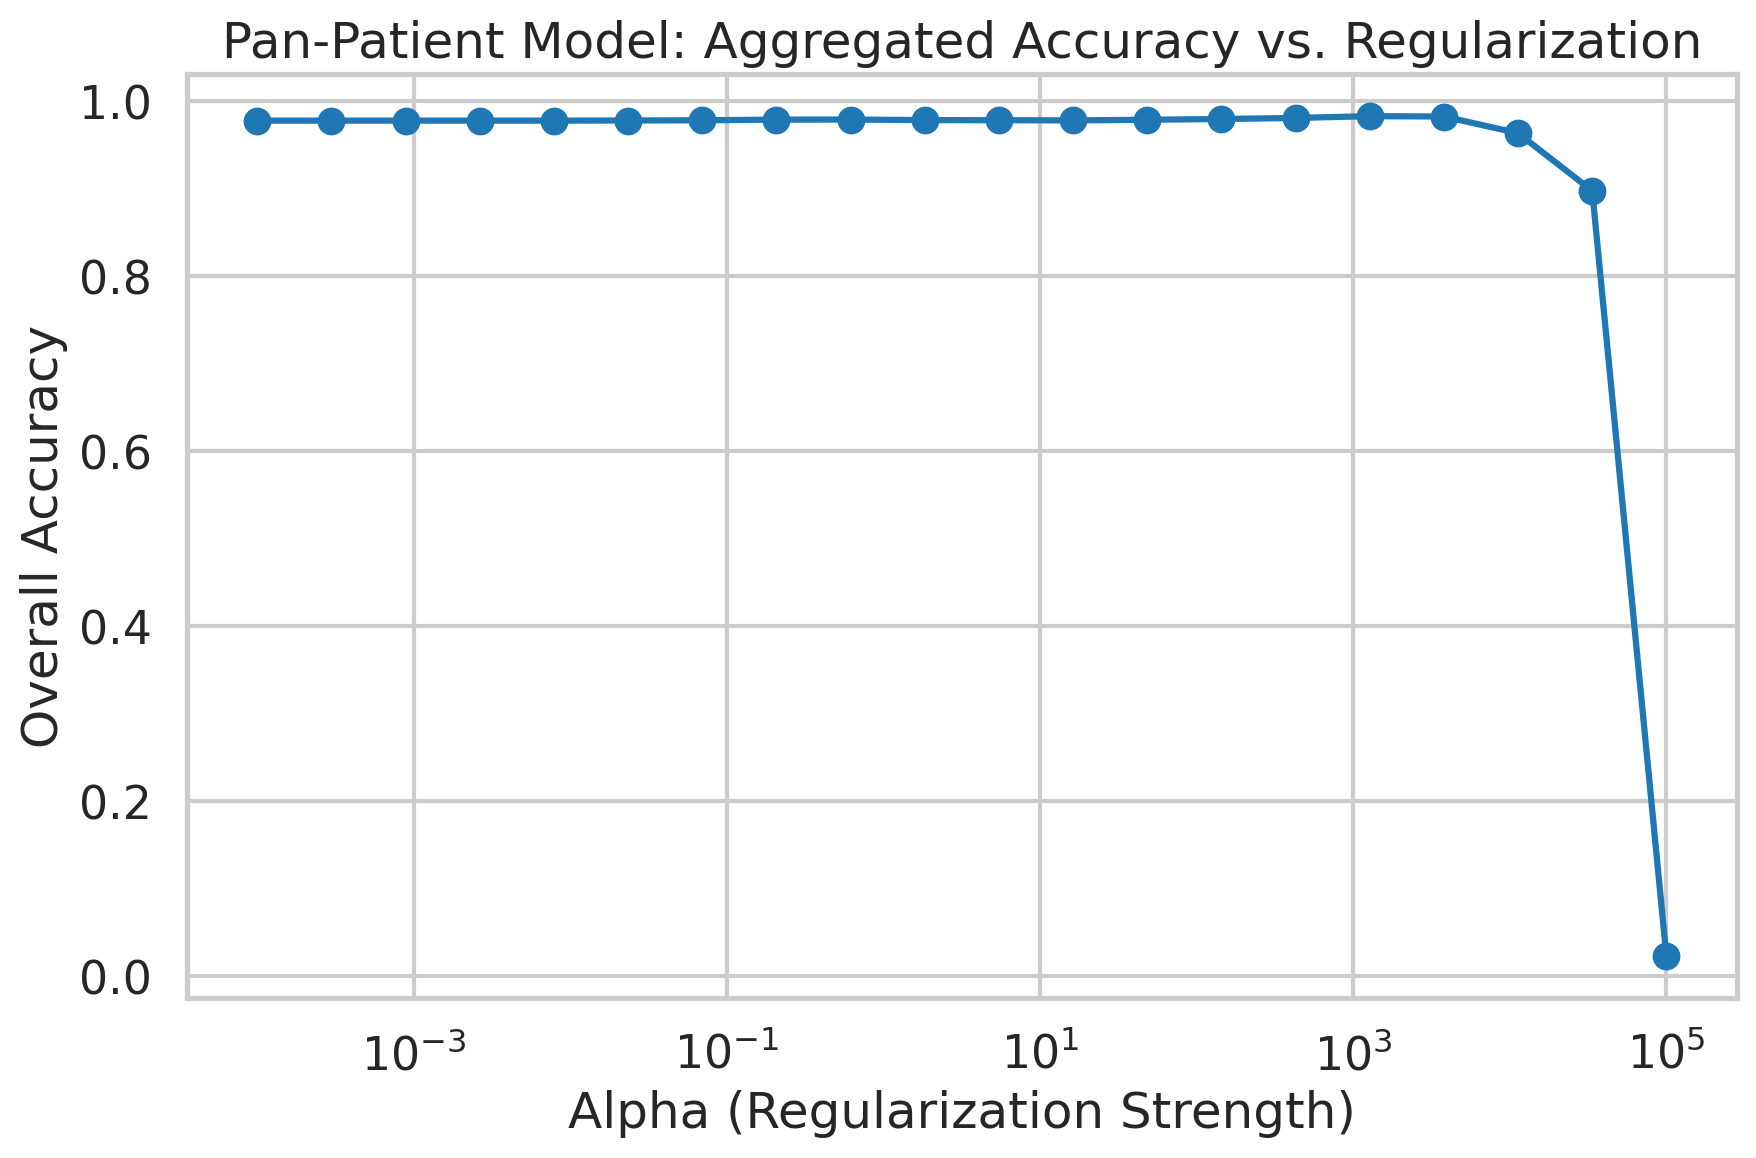


Analyzing heterogeneity at best alpha: 1.27e+03


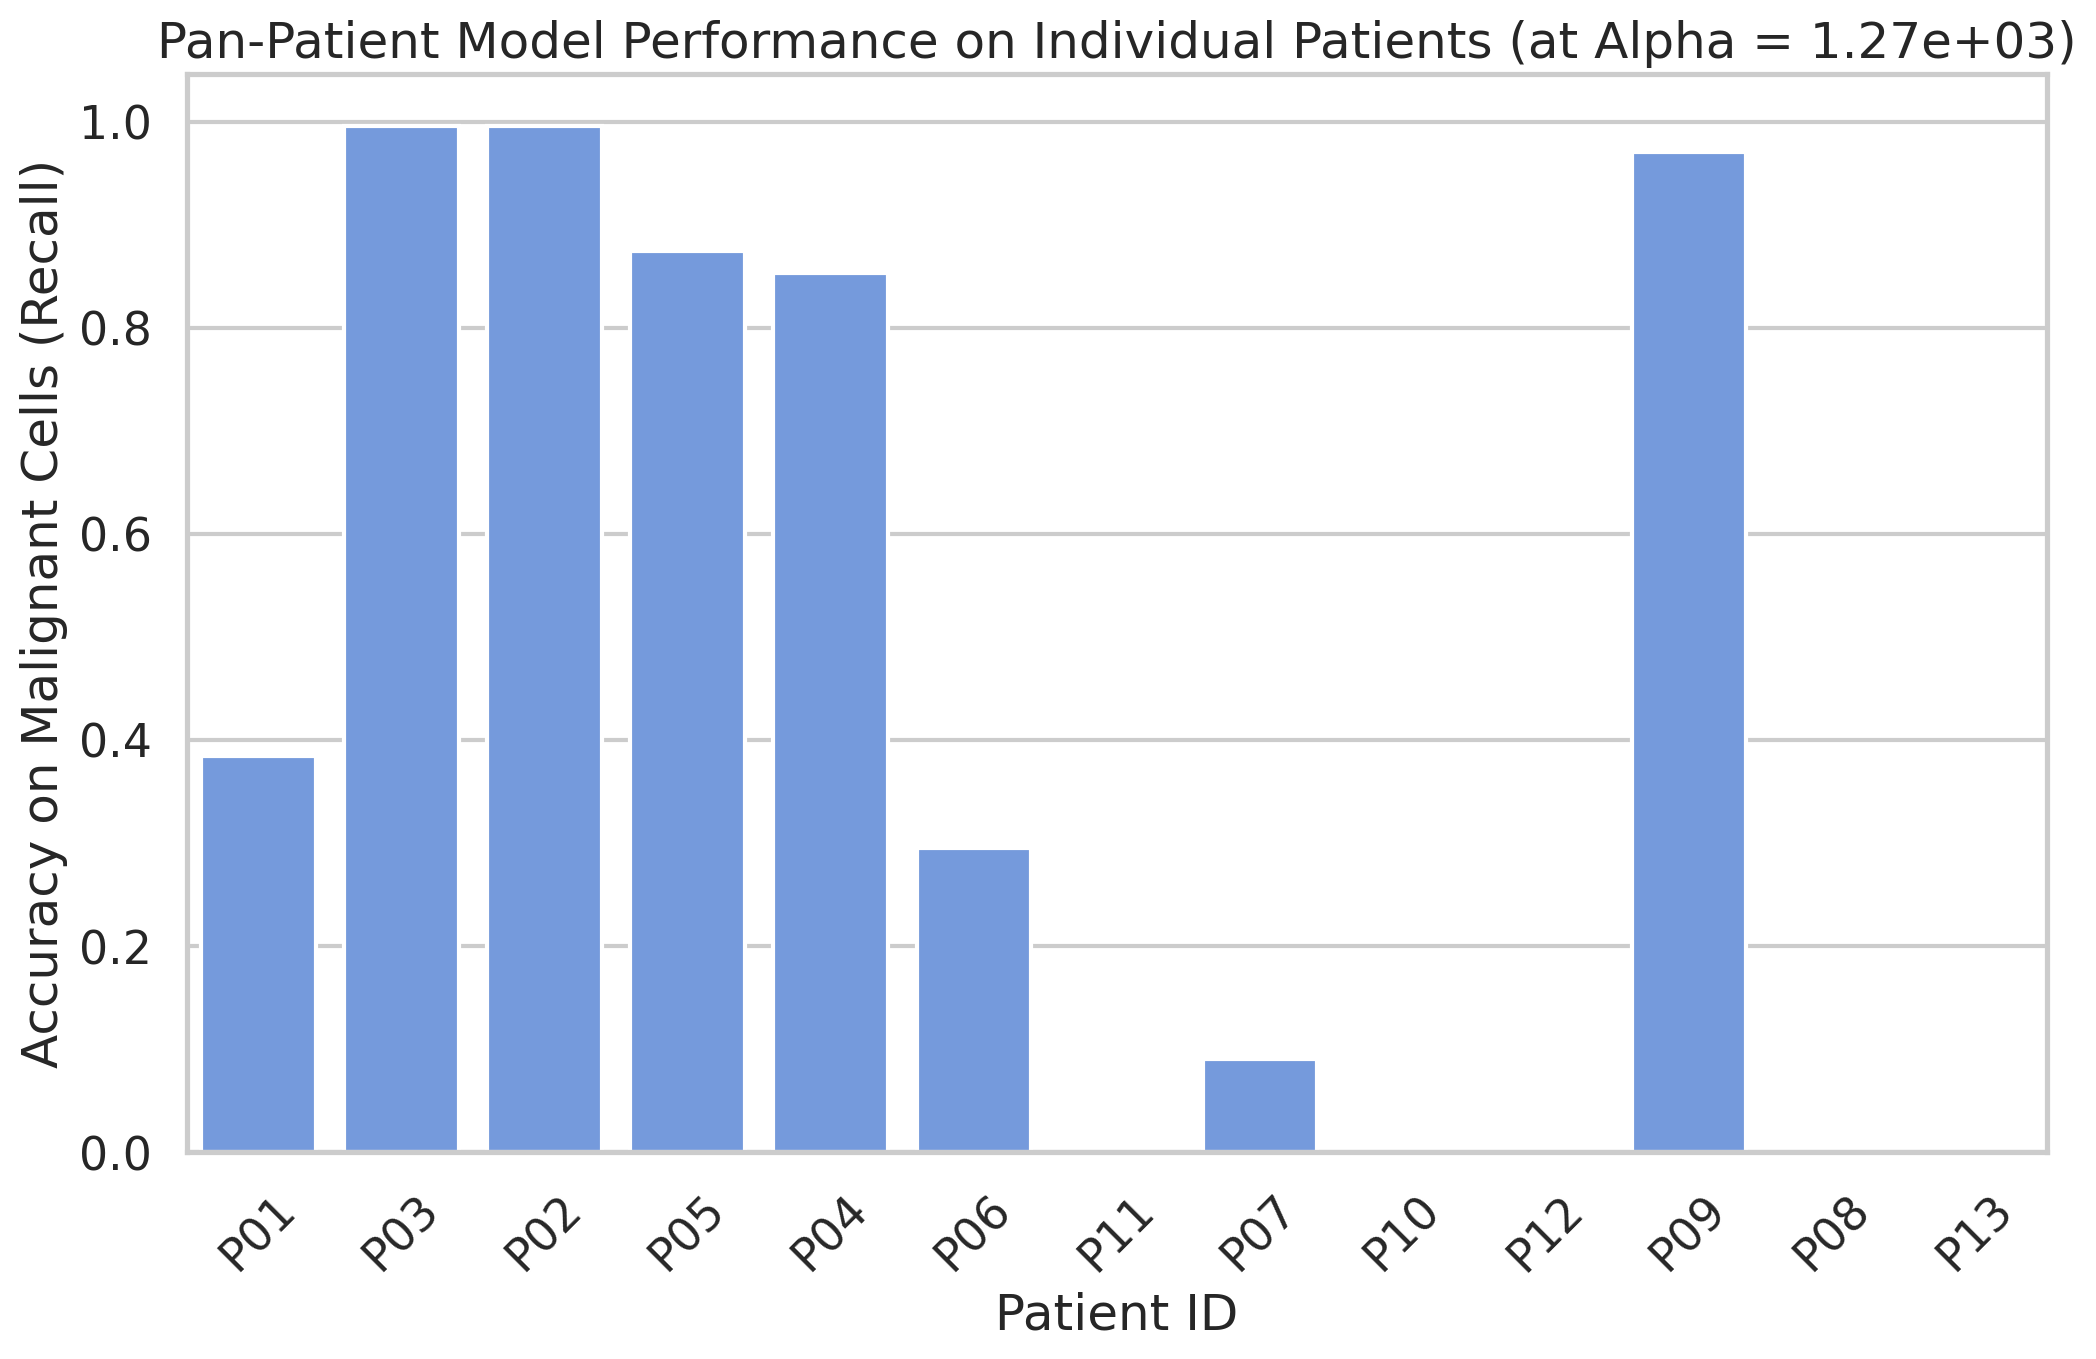

In [7]:
# In a new cell: Analyze and Aggregate Pan-Patient Metrics

# We will focus on the non-CV run for this analysis
exp_id = pan_patient_experiments['no_cv']['id']
exp_path = pan_patient_experiments['no_cv']['path']
print(f"--- Analyzing metrics for Pan-Patient experiment: {exp_id} ---")

# Load the per-patient metrics file generated by the pan-patient run
metrics_path = exp_path / "models" / "classification" / "all_patients" / "metrics.csv"
per_patient_metrics_df = pd.read_csv(metrics_path)

# 1. AGGREGATE METRICS to get a true pan-patient view
# Group by alpha and sum the fundamental counts
agg_metrics = per_patient_metrics_df.groupby('alpha')[['tp', 'fp', 'tn', 'fn']].sum().reset_index()

# Recalculate pan-patient accuracy
agg_metrics['pan_patient_accuracy'] = (agg_metrics['tp'] + agg_metrics['tn']) / \
                                      (agg_metrics['tp'] + agg_metrics['tn'] + agg_metrics['fp'] + agg_metrics['fn'])

# Plot the aggregated pan-patient accuracy
plt.figure(figsize=(10, 6))
plt.plot(agg_metrics['alpha'], agg_metrics['pan_patient_accuracy'], 'o-')
plt.xscale('log')
plt.title('Pan-Patient Model: Aggregated Accuracy vs. Regularization')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Overall Accuracy')
plt.grid(True)
plt.show()


# 2. VISUALIZE HETEROGENEITY by plotting performance across patients
# We'll select a single, high-performing alpha to make the plot clear.
# Let's pick the alpha that gave the best pan-patient accuracy.
best_alpha = agg_metrics.loc[agg_metrics['pan_patient_accuracy'].idxmax()]['alpha']
metrics_at_best_alpha = per_patient_metrics_df[per_patient_metrics_df['alpha'] == best_alpha].set_index('group')

print(f"\nAnalyzing heterogeneity at best alpha: {best_alpha:.2e}")

plt.figure(figsize=(12, 7))
# Plot accuracy on malignant cells (recall) for each patient
sns.barplot(x=metrics_at_best_alpha.index, y=metrics_at_best_alpha['mal_accuracy'], color='cornflowerblue')
plt.title(f'Pan-Patient Model Performance on Individual Patients (at Alpha = {best_alpha:.2e})')
plt.ylabel('Accuracy on Malignant Cells (Recall)')
plt.xlabel('Patient ID')
plt.xticks(rotation=45)
plt.show()


In [8]:
per_patient_metrics_df

,tp,fp,tn,fn,overall_accuracy,mal_accuracy,mal_precision,mal_recall,mal_f1,norm_accuracy,...,norm_f1,trivial_accuracy,majority_num,minority_num,roc_auc,group,alpha,fpr,tpr,thresholds
0,41,289,18610,24,0.983495,0.630769,0.124242,0.630769,0.207595,0.984708,...,0.991661,0.996572,18899,65,0.958027,P01,0.0001,"[0.00000000e+00,0.00000000e+00,0.00000000e+00,...","[0. ,0.01538462,0.10769231,0.10769231,0...","[ inf,9.99417985e-01,9.95291922e-01,..."
1,756,34,3246,2,0.991085,0.997361,0.956962,0.997361,0.976744,0.989634,...,0.994485,0.812283,3280,758,0.999932,P03,0.0001,"[0.00000000e+00,0.00000000e+00,0.00000000e+00,...","[0. ,0.43403694,0.49340369,0.51055409,0...","[ inf,1.00000000e+00,1.00000000e+00,..."
2,230,126,1974,0,0.945923,1.000000,0.646067,1.000000,0.784983,0.940000,...,0.969072,0.901288,2100,230,0.992395,P02,0.0001,"[0.00000000e+00,0.00000000e+00,0.00000000e+00,...","[0. ,0.00434783,0.0173913 ,0.0173913 ,0...","[ inf,9.99999999e-01,9.99999997e-01,..."
3,7,42,4309,1,0.990135,0.875000,0.142857,0.875000,0.245614,0.990347,...,0.995035,0.998165,4351,8,0.995030,P05,0.0001,"[0.00000000e+00,0.00000000e+00,0.00000000e+00,...","[0. ,0.125,0.25 ,0.25 ,0.375,0.375,0.5 ,0.5...","[ inf,9.99881835e-01,9.88804151e-01,..."
4,97,218,808,5,0.802305,0.950980,0.307937,0.950980,0.465228,0.787524,...,0.878738,0.909574,1026,102,0.965495,P04,0.0001,"[0.00000000e+00,0.00000000e+00,0.00000000e+00,...","[0. ,0.00980392,0.10784314,0.10784314,0...","[ inf,9.99999998e-01,9.99991430e-01,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,0,2715,0,0,0.000000,NaN,NaN,NaN,NaN,0.000000,...,0.000000,1.000000,2715,0,NaN,P10,100000.0000,"[0.,1.]","[nan,nan]","[ inf,0.50274117]"
256,0,2488,0,0,0.000000,NaN,NaN,NaN,NaN,0.000000,...,0.000000,1.000000,2488,0,NaN,P12,100000.0000,"[0.,1.]","[nan,nan]","[ inf,0.50274117]"
257,374,16752,0,0,0.021838,1.000000,0.021838,1.000000,0.042743,0.000000,...,0.000000,0.978162,16752,374,0.500000,P09,100000.0000,"[0.,1.]","[0.,1.]","[ inf,0.50274117]"
258,0,1411,0,0,0.000000,NaN,NaN,NaN,NaN,0.000000,...,0.000000,1.000000,1411,0,NaN,P08,100000.0000,"[0.,1.]","[nan,nan]","[ inf,0.50274117]"


In [3]:
print("--- Generating 2-Panel Reports for Pan-Patient Experiments ---")

# Initialize the analyzer
manager = ExperimentManager(BASE_EXPERIMENT_DIR)
analyzer = ExperimentAnalyzer(manager)

# --- Generate the 2-panel plot for the "No CV" run ---
# The function will now automatically handle the aggregation and plotting
analyzer.generate_lasso_path_2panels_report(pan_patient_experiments['no_cv']['id'])

# --- Generate the 2-panel plot for the "with CV" run ---
analyzer.generate_lasso_path_2panels_report(pan_patient_experiments['with_cv']['id'])

print("\nPan-patient analysis complete.")

--- Generating 2-Panel Reports for Pan-Patient Experiments ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250812_190804_fa_100_none_all_filtered_e2c36430
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250812_215722_fa_100_none_all_filtered_cfd8482f

Pan-patient analysis complete.


In [7]:
# --- Setup for Pan-Patient Analysis ---
# Assuming 'analyzer' and 'pan_patient_experiments' are already defined in your notebook.

# 1. Select the 'no_cv' pan-patient experiment ID
exp_id = pan_patient_experiments['no_cv']['id']
patient_id = 'all_patients'
print(f"Target Experiment ID: {exp_id}")
print(f"Target Patient/Group: {patient_id}")


# 2. Define the range of regularization strength indices to analyze.
# These indices correspond to the steps along the LASSO path you want to inspect.
indices_to_analyze = [12, 13, 14, 15, 16, 17, 18, 19]
print(f"Indices to analyze: {indices_to_analyze}")

# The analysis functions expect a dictionary format, even for a single pan-patient group.
patient_indices_dict = {
    patient_id: indices_to_analyze
}

Target Experiment ID: 20250812_190804_fa_100_none_all_filtered_e2c36430
Target Patient/Group: all_patients
Indices to analyze: [12, 13, 14, 15, 16, 17, 18, 19]


In [8]:
# --- 1. Analyze Classification Transitions ---
# This function calculates which factors are "discovered" and which cells "flip"
# from incorrect to correct at each step in the regularization path.
# The results are cached in a JSON file for the UMAP plotting function to use.

print(f"\n--- Running Classification Transition Analysis for Experiment: {exp_id} ---")

analyzer.analyze_classification_transitions(
    experiment_id=exp_id,
    patient_id=patient_id,
    indices_to_check=indices_to_analyze
)

print("\n--- Transition analysis complete. ---")


--- Running Classification Transition Analysis for Experiment: 20250812_190804_fa_100_none_all_filtered_e2c36430 ---
--- Analyzing Classification Transitions for Patient all_patients ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250812_190804_fa_100_none_all_filtered_e2c36430
  Analyzing transition from index 19 to 18...
  Analyzing transition from index 18 to 17...
  Analyzing transition from index 17 to 16...
  Analyzing transition from index 16 to 15...
  Analyzing transition from index 15 to 14...
  Analyzing transition from index 14 to 13...
  Analyzing transition from index 13 to 12...

Successfully saved transition analysis to: /home/minhang/mds_project/sc_classification/experiments/20250812_190804_fa_100_none_all_filtered_e2c36430/models/classification/all_patients/classification_transitions.json

--- Transition analysis complete. ---


In [9]:
# --- 2. Generate Classification UMAP Report ---
# This function uses the transition data to generate two sets of UMAPs:
# 1. Static UMAPs: Shows classification status on a single, consistent UMAP layout.
# 2. Dynamic UMAPs: Creates a new UMAP for each regularization step, using only the factors active at that step.

print(f"\n--- Generating Classification UMAPs for Experiment: {exp_id} ---")

analyzer.generate_classification_umap_report(
    experiment_id=exp_id,
    patient_reg_strength_indices=patient_indices_dict,
    static_umap_rep='X_fa' # Using the FA representation as the static background
)

print("\n--- UMAP report generation complete. ---")


--- Generating Classification UMAPs for Experiment: 20250812_190804_fa_100_none_all_filtered_e2c36430 ---
--- Generating Classification UMAP Report for Experiment: 20250812_190804_fa_100_none_all_filtered_e2c36430 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250812_190804_fa_100_none_all_filtered_e2c36430

Processing patient: all_patients
  Generating Static UMAPs based on: 'X_fa'
  Finished static UMAPs for patient all_patients.
  Generating Dynamic UMAPs based on selected 'fa' factors
    Index 19: Only 1 active factor. Attempting fallback.


/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


  Finished dynamic UMAPs for patient all_patients.

--- Report generation complete. ---

--- UMAP report generation complete. ---


In [10]:
# --- 3. Run GSEA on Predictive Loadings ---
# For each specified regularization index, this computes a "predictive loading"
# vector (Loadings @ Coefficients) and runs GSEA on it. This provides a biological
# interpretation of the model's gene signature at each step of the LASSO path,
# which can be linked to the corresponding UMAPs.

print(f"\n--- Running GSEA on Predictive Loadings for Experiment: {exp_id} ---")

for alpha_idx in indices_to_analyze:
    print(f"\n--- GSEA for alpha index: {alpha_idx} ---")
    analyzer.run_gsea_on_predictive_loading(
        experiment_id=exp_id,
        patient_id=patient_id,
        alpha_index=alpha_idx
    )

print("\n--- GSEA analysis complete. ---")


--- Running GSEA on Predictive Loadings for Experiment: 20250812_190804_fa_100_none_all_filtered_e2c36430 ---

--- GSEA for alpha index: 12 ---
--- Running GSEA on Predictive Loading for Patient all_patients at alpha index 12 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250812_190804_fa_100_none_all_filtered_e2c36430
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250812_190804_fa_100_none_all_filtered_e2c36430/analysis/supervised_gsea/all_patients/alpha_idx_12

--- GSEA for alpha index: 13 ---
--- Running GSEA on Predictive Loading for Patient all_patients at alpha index 13 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250812_190804_fa_100_none_all_filtered_e2c36430
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250812_190804_fa_100_none_all_filtered_e2c36430/analysis/supervised_gsea/all_patients/alpha_idx_13

--- GSEA for alpha index: 14 ---
--- Running GSEA on Predictive Loading for Patient all_patients at alpha index 14 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250812_190804_fa_100_none_all_filtered_e2c36430
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250812_190804_fa_100_none_all_filtered_e2c36430/analysis/supervised_gsea/all_patients/alpha_idx_14

--- GSEA for alpha index: 15 ---
--- Running GSEA on Predictive Loading for Patient all_patients at alpha index 15 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250812_190804_fa_100_none_all_filtered_e2c36430
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250812_190804_fa_100_none_all_filtered_e2c36430/analysis/supervised_gsea/all_patients/alpha_idx_15

--- GSEA for alpha index: 16 ---
--- Running GSEA on Predictive Loading for Patient all_patients at alpha index 16 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250812_190804_fa_100_none_all_filtered_e2c36430
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250812_190804_fa_100_none_all_filtered_e2c36430/analysis/supervised_gsea/all_patients/alpha_idx_16

--- GSEA for alpha index: 17 ---
--- Running GSEA on Predictive Loading for Patient all_patients at alpha index 17 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250812_190804_fa_100_none_all_filtered_e2c36430
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250812_190804_fa_100_none_all_filtered_e2c36430/analysis/supervised_gsea/all_patients/alpha_idx_17

--- GSEA for alpha index: 18 ---
--- Running GSEA on Predictive Loading for Patient all_patients at alpha index 18 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250812_190804_fa_100_none_all_filtered_e2c36430
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250812_190804_fa_100_none_all_filtered_e2c36430/analysis/supervised_gsea/all_patients/alpha_idx_18

--- GSEA for alpha index: 19 ---
--- Running GSEA on Predictive Loading for Patient all_patients at alpha index 19 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250812_190804_fa_100_none_all_filtered_e2c36430
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250812_190804_fa_100_none_all_filtered_e2c36430/analysis/supervised_gsea/all_patients/alpha_idx_19

--- GSEA analysis complete. ---
